<a href="https://colab.research.google.com/github/akemiyamashita/Trainable_Segmentation/blob/master/forHospitalHisayama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import tensorflow as tf

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
sns.set_style("whitegrid")

In [0]:
from os import makedirs
makedirs('data',exist_ok = True)

In [0]:
cross_csv = pd.read_csv('/content/cardiac FHR - Sheet30.csv')
a = cross_csv['Target']
b = cross_csv['high']

crossed = pd.crosstab(a,b)
print(crossed)

high     0    1
Target         
0       92  100
1       22   29
2        8    5
3        1    2


In [0]:
def binary_target(x):
  if x ==0:
    return 0
  else:
    return 1

In [0]:
cross_csv['CCT'] = cross_csv['Target'].apply(binary_target)

In [0]:
a = cross_csv['CCT']

crossed = pd.crosstab(a,b)
print(crossed)

high   0    1
CCT          
0     92  100
1     31   36


In [0]:
from statsmodels.stats.power import tt_ind_solve_power

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

nsample = a.size
X = np.column_stack((np.repeat(1, nsample), a, a**2))

model = sm.OLS(b, X)
results = model.fit()
print(results)

x,y,z = results.params

In [0]:
import scipy as sp
import scipy.stats
x2, p, dof, expected = sp.stats.chi2_contingency(crossed)

print("カイ二乗値は %(x2)s" %locals() )
print("確率は %(p)s" %locals() )
print("自由度は %(dof)s" %locals() )
print( expected )

if p < 0.05:
    print("関連がない")
else:
    print("関連がある")

カイ二乗値は 0.008191955980722226
確率は 0.9278824047735884
自由度は 1
[[ 91.18146718 100.81853282]
 [ 31.81853282  35.18146718]]
有意な差がありません


In [0]:
train_df = pd.read_csv('/content/forHospital - train.csv')
test_df = pd.read_csv('/content/forHospital - test.csv')

In [4]:
train_df.shape

(228, 33)

In [0]:
test_df.describe()

CCT            ID        sex  ...  CVD_DEATH        BNF        ASSIGN
count  31.000000  3.100000e+01  31.000000  ...  31.000000  31.000000  3.100000e+01
mean    1.096774  4.805811e+07   0.677419  ...  10.692136  23.456464  5.908238e+01
std     1.491193  1.416386e+07   0.475191  ...   7.042807  13.995467  4.664179e+01
min     0.000000  8.020805e+06   0.000000  ...   0.401490   0.001355  6.059309e-09
25%     0.000000  4.153166e+07   0.000000  ...   3.618172  13.281662  7.316015e+00
50%     1.000000  4.707266e+07   1.000000  ...  11.933859  24.598550  9.999730e+01
75%     2.000000  5.254083e+07   1.000000  ...  16.133604  33.886288  1.000000e+02
max     6.000000  7.712221e+07   1.000000  ...  23.326406  51.544327  1.000000e+02

[8 rows x 33 columns]

In [0]:
all = pd.concat([train_df, test_df], sort=False)

包括的リスク評価 - J-Stage
https://www.jstage.jst.go.jp/article/jcoron/24/1/24_24.002/_pdf
by 岡村智教 - ‎2018 - ‎Related articles

In [0]:
def binary_CCT(x):
  if x >=1:
    return 1
 
  else:
    return 0

In [0]:
all['CCT'] = all['CCT'].apply(binary_CCT)

In [0]:
def hisa_age_cat(x):
  if x <=44:
    return 30
  elif x >=45 and x <=54:
    return 38
  elif x>=55 and x <=64:
    return 45
  elif x >=65 and x <=69:
    return 51
  else:
    return 53

In [0]:
all['hisa_age'] = all['age'].apply(hisa_age_cat)

In [0]:
def gen_bias(x):
  if x >=1:
    return 0
  else:
    return -7

In [0]:
all['gendar_bias'] =all['sex'].apply(gen_bias)

In [0]:
def maxBP_high(x):
  if x <120:
    return -7
  elif x >=120 and x <=139:
    return 0
  elif x >=140 and x <=159:
    return 4
  else:
    return 6

In [0]:
all['BPmax_high'] = all['BP _max'].apply(maxBP_high)

In [0]:
def minBP_high(x):
  if x <80:
    return -7
  elif x >=80 and x <=89:
    return 0
  elif x >=90 and x <=99:
    return 4
  else:
    return 6

In [0]:
all['BPmin_high'] = all['BP_min'].apply(minBP_high)

In [0]:
def HDLC(x):
  if x <40:
    return 0
  elif 40<=x and x <=59:
    return -5
  else:
    return -6
    

In [0]:
all['HDLC'] = all['HDL-Cho'].apply(HDLC)

In [0]:
def LDLC(x):
  if x <100:
    return 0
  elif 100<=x and x <=139:
    return 5
  elif 140<=x and x <=159:
    return 7
  elif 160<=x and x <=179:
    return 10
  else:
    return 11

In [0]:
all['LDLC'] = all['LDL-Cho'].apply(LDLC)

In [0]:
def sugar(x):
  if x >= 5.5:
    return 5
  else:
    return 0

In [0]:
all['sugar']= all['HbA1c(NGSP)'].apply(sugar)

In [0]:
all['fam'] = all['family'] *5

In [0]:
all['heartFailure'] =all['heartdesease'] *5

In [0]:
all['hisayama'] =all['hisa_age']+all['gendar_bias']+((all['BPmax_high']+all['BPmin_high'])/2)+all['HDLC']+all['LDLC']+all['sugar']+all['fam']+all['heartFailure']

hisayama <40, low 41<x <55 middle, 55<=high

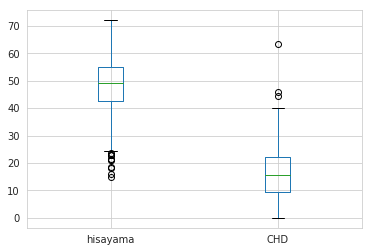

In [25]:
box =all.boxplot(column = ['hisayama','CHD'])

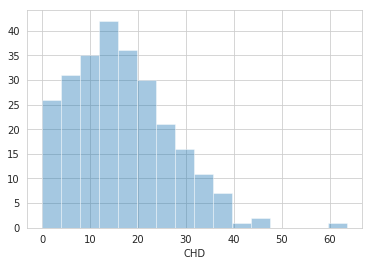

In [0]:
sns.distplot(all['CHD'],kde = False, hist=True)

0    135
1     63
2     22
3     18
4     10
6      5
5      5
8      1
Name: CCT, dtype: int64

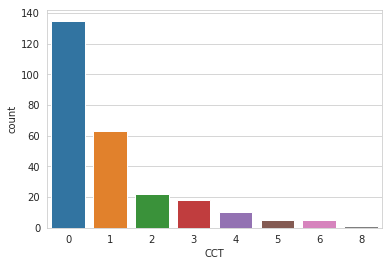

In [0]:
sns.countplot(x = 'CCT', data=all)
all['CCT'].value_counts()

In [26]:
all['HDL-Cho/HbA1c'] = all['HbA1c(NGSP)']/all['HDL-Cho']
all['LDL-Cho*HbA1c'] = all['LDL-Cho']*all['HbA1c(NGSP)']
all['LDL/HDL*HbA1c'] = all['LDL/HDL']*all['HbA1c(NGSP)']
all['total_Cho*HbA1c'] = all['total_Cho']*all['HbA1c(NGSP)']

all['BPdistance'] = all['BP _max'] - all['BP_min']

all['DM_HT_HL'] = all['DM']*all['HyperTension']*all['dislipidemia']
all['DM_HT'] = all['DM']* all['HyperTension']
all['DM_HL'] = all['DM'] * all['dislipidemia']

all['age60-'] = (all['age'] - 60 )*10

all['HDL-Cho*HbA1c_smoking'] = all['HDL-Cho']*all['HbA1c(NGSP)']*all['smoking']
all['LDL-Cho*HbA1c_smoking'] = all['LDL-Cho']*all['HbA1c(NGSP)']*all['smoking']
all['LDL/HDL*HbA1c_smoking'] = all['LDL/HDL']*all['HbA1c(NGSP)']*all['smoking']
all['total_Cho*HbA1c_smoking'] = all['total_Cho']*all['HbA1c(NGSP)']*all['smoking']

all['BPdistance_smoiking'] = (all['BP _max'] - all['BP_min'])*all['smoking']

all['DM_HT_HL_smoking'] = all['DM']*all['HyperTension']*all['dislipidemia']*all['smoking']
all['DM_HT_smoking'] = all['DM']*all['HyperTension']*all['smoking']
all['DM_HL_smoking'] = all['DM']*all['dislipidemia']*all['smoking']

all['total_ChoabNormal'] = (all['total_Cho'] -130) >= 0
all['LDL-ChoabNormal'] = (all['LDL-Cho'] -120) >= 0
all['HDL-ChoabNormal']= ( 50 - all['HDL-Cho']) >= 0

all['HbA1c(NGSP)abnormal'] = (all['HbA1c(NGSP)']-6) >=0

all['abnormalcho'] = all['total_ChoabNormal']*all['LDL-ChoabNormal']*all['HDL-ChoabNormal']
all['abnormal'] = all['abnormalcho']*all['HbA1c(NGSP)abnormal']

all['DMnoncontrol'] =all['DM'] * all['HbA1c(NGSP)abnormal']
all['HTnoncontrol'] =all['BPdistance'] * all['HyperTension']
all['HLnoncontrol'] =all['dislipidemia'] * all['abnormalcho'] 

all['CHDrisk'] = all['CHD'] >9


/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [0]:
from sklearn import linear_model

clf = linear_model.LinearRegression()

In [28]:
all[['CCT','hisayama']].corr()

CCT  hisayama
CCT       1.000000 -0.022733
hisayama -0.022733  1.000000

In [29]:
all[['CCT','CHD']].corr()

CCT       CHD
CCT  1.000000 -0.033655
CHD -0.033655  1.000000

In [0]:
all.shape

(259, 70)

In [0]:
train_df = all[0:228].copy()
test_df = all[228:].copy()

In [31]:
train_df.head(3)

CCT        ID  sex  DM  ...  DMnoncontrol  HTnoncontrol  HLnoncontrol  CHDrisk
0    1  37033161    0   0  ...             0            72             0    False
1    0  52052006    1   1  ...             0            62             0     True
2    0  41021305    1   0  ...             0            58             0     True

[3 rows x 70 columns]

In [0]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score, KFold

In [0]:
target = train_df['CCT']

In [0]:
train_df = train_df.drop(['CCT'],axis =1)

In [0]:
features = train_df.columns

In [37]:
selector = SelectKBest(f_classif, k=len(features))
selector.fit(train_df[features], target)
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]
print("Features importance :")
for f in range(len(scores)):
    print("%0.2f %s" % (scores[indices[f]],features[indices[f]]))

Features importance :
1.69 family
1.69 fam
1.65 LDL-ChoabNormal
1.49 LDL/HDL*HbA1c
1.48 DM_HT_HL_smoking
1.38 HDL-Cho/HbA1c
1.33 abnormalcho
1.25 HDLC
1.22 DM_HT_smoking
1.17 DM_HT_HL
1.16 LDL/HDL
1.05 DM_HT
1.03 sugar
1.02 HbA1c(NGSP)abnormal
0.98 HDL-Cho*HbA1c_smoking
0.85 BPmin_high
0.83 CREA
0.79 DMnoncontrol
0.79 ECG
0.78 DM_HL_smoking
0.77 BPdistance
0.71 gendar_bias
0.71 sex
0.71 STROKE
0.70 smoking
0.69 BPdistance_smoiking
0.68 HbA1c(NGSP)
0.67 HLnoncontrol
0.67 lung
0.66 HDL-Cho
0.62 LDL-Cho*HbA1c
0.59 HDL-ChoabNormal
0.50 eGFR
0.42 alcohol
0.40 LDLC
0.37 total_Cho*HbA1c
0.37 BP_min
0.36 kidney
0.35 BNF
0.35 total_Cho*HbA1c_smoking
0.33 LDL-Cho
0.32 DM_HL
0.30 LDL-Cho*HbA1c_smoking
0.29 ID
0.27 MI
0.26 ASSIGN
0.26 CHDrisk
0.24 CVD
0.23 dislipidemia
0.22 BP _max
0.21 DM
0.21 brain
0.20 CHD_DEATH
0.16 total_ChoabNormal
0.14 body_pain
0.14 abnormal
0.12 HyperTension
0.11 age
0.11 age60-
0.11 total_Cho
0.09 CHD
0.08 BPmax_high
0.06 hisa_age
0.05 hisayama
0.03 CVD_DEATH
0.03 HTnonc

In [0]:
rfc = RandomForestClassifier(n_estimators=3000, min_samples_split=4, class_weight={0:0.745,1:0.255})

In [39]:
kf = KFold(n_splits=3, random_state=1)
scores = cross_val_score(rfc, train_df[features], target, cv=kf)
print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean()*100, scores.std()*100, 'RFC Cross Validation'))

Accuracy: 57.456 (+/- 1.64) [RFC Cross Validation]


In [40]:
rfc.fit(train_df[features], target)
score = rfc.score(train_df[features], target)
print("Accuracy: %0.3f            [%s]" % (score*100, 'RFC full test'))

Accuracy: 99.561            [RFC full test]


In [0]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(features)):
    print("%d. feature %d (%f) %s" % (f+1, indices[f]+1, importances[indices[f]]*100, features[indices[f]]))
    

1. feature 47 (4.320679) BPdistance
2. feature 11 (4.243955) BP_min
3. feature 27 (4.133361) STROKE
4. feature 13 (3.959710) eGFR
5. feature 10 (3.694883) BP _max
6. feature 46 (3.489924) total_Cho*HbA1c
7. feature 45 (3.444408) LDL/HDL*HbA1c
8. feature 44 (3.352243) LDL-Cho*HbA1c
9. feature 43 (2.973616) HDL-Cho/HbA1c
10. feature 12 (2.967324) CREA
11. feature 17 (2.924011) LDL/HDL
12. feature 16 (2.845747) LDL-Cho
13. feature 14 (2.734918) total_Cho
14. feature 18 (2.711264) HbA1c(NGSP)
15. feature 26 (2.669916) MI
16. feature 30 (2.637225) CVD_DEATH
17. feature 42 (2.622137) hisayama
18. feature 28 (2.602419) CVD
19. feature 29 (2.573764) CHD_DEATH
20. feature 1 (2.556052) ID
21. feature 31 (2.546914) BNF
22. feature 25 (2.423466) CHD
23. feature 15 (2.137159) HDL-Cho
24. feature 67 (2.125935) HTnoncontrol
25. feature 51 (2.082857) age60-
26. feature 6 (2.026611) age
27. feature 55 (1.856075) total_Cho*HbA1c_smoking
28. feature 52 (1.649933) HDL-Cho*HbA1c_smoking
29. feature 56 (1.6

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


In [0]:
predictions = rfc.predict(test_df[features])

In [0]:
Id =np.array(test_df["ID"]).astype(int)
my_prediction = pd.DataFrame(predictions, Id, columns = ["CCT"])

my_prediction.to_csv("submission1.csv", index_label = ["ID"])

In [0]:
pred = pd.read_csv('/content/submission1.csv')
pred.head(5)

ID  CCT
0  46070751    1
1  39020801    1
2  37041151    0
3  47072655    0
4  41021207    0

In [0]:
import shutil

shutil.move('/content/submission1.csv','/content/gdrive/My Drive/heart')



'/content/gdrive/My Drive/heart/submission1.csv'

In [0]:
a = pd.read_csv('/content/gdrive/My Drive/heart/output.csv')
b = pd.read_csv('/content/gdrive/My Drive/heart/output1class.csv')
c = pd.read_csv('/content/gdrive/My Drive/heart/output9class.csv')
d = pd.read_csv('/content/gdrive/My Drive/heart/outputparam.csv')
e = pd.read_csv('/content/gdrive/My Drive/heart/outputparam2.csv')
f= pd.read_csv('/content/gdrive/My Drive/heart/submission.csv')

In [0]:
compare = pd.concat([a,b,c,d,e,f],sort=False, axis =1)

In [0]:
compare[1:5]

Unnamed: 0        ID  CCT  Unnamed: 0  ...        ID  CCT        ID  CCT
1           1  39020801    1           1  ...  39020801    1  39020801    1
2           2  37041151    0           2  ...  37041151    0  37041151    1
3           3  47072655    0           3  ...  47072655    0  47072655    1
4           4  41021207    0           4  ...  41021207    0  41021207    0

[4 rows x 17 columns]

In [0]:
Y = train_df.pop('CCT')

In [0]:
X = train_df

In [0]:
from sklearn.model_selection import train_test_split

train_x,test_x,train_y,test_y = train_test_split(X,Y)

In [0]:
clf.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# 回帰係数
print('回帰係数：'+str(clf.coef_[0]))

# 切片 (誤差)
print('切片：'+str(clf.intercept_))

# 決定係数
print('決定係数：'+str(clf.score(X, Y)))


回帰係数：3.970205662153449e-09
切片：-3.661297456598696
決定係数：0.1665857186065678


決定係数は、説明変数がどれだけ目的変数（を説明できているかを表しています。今回の結果では0.133なので寄与率が約13%ということです。

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


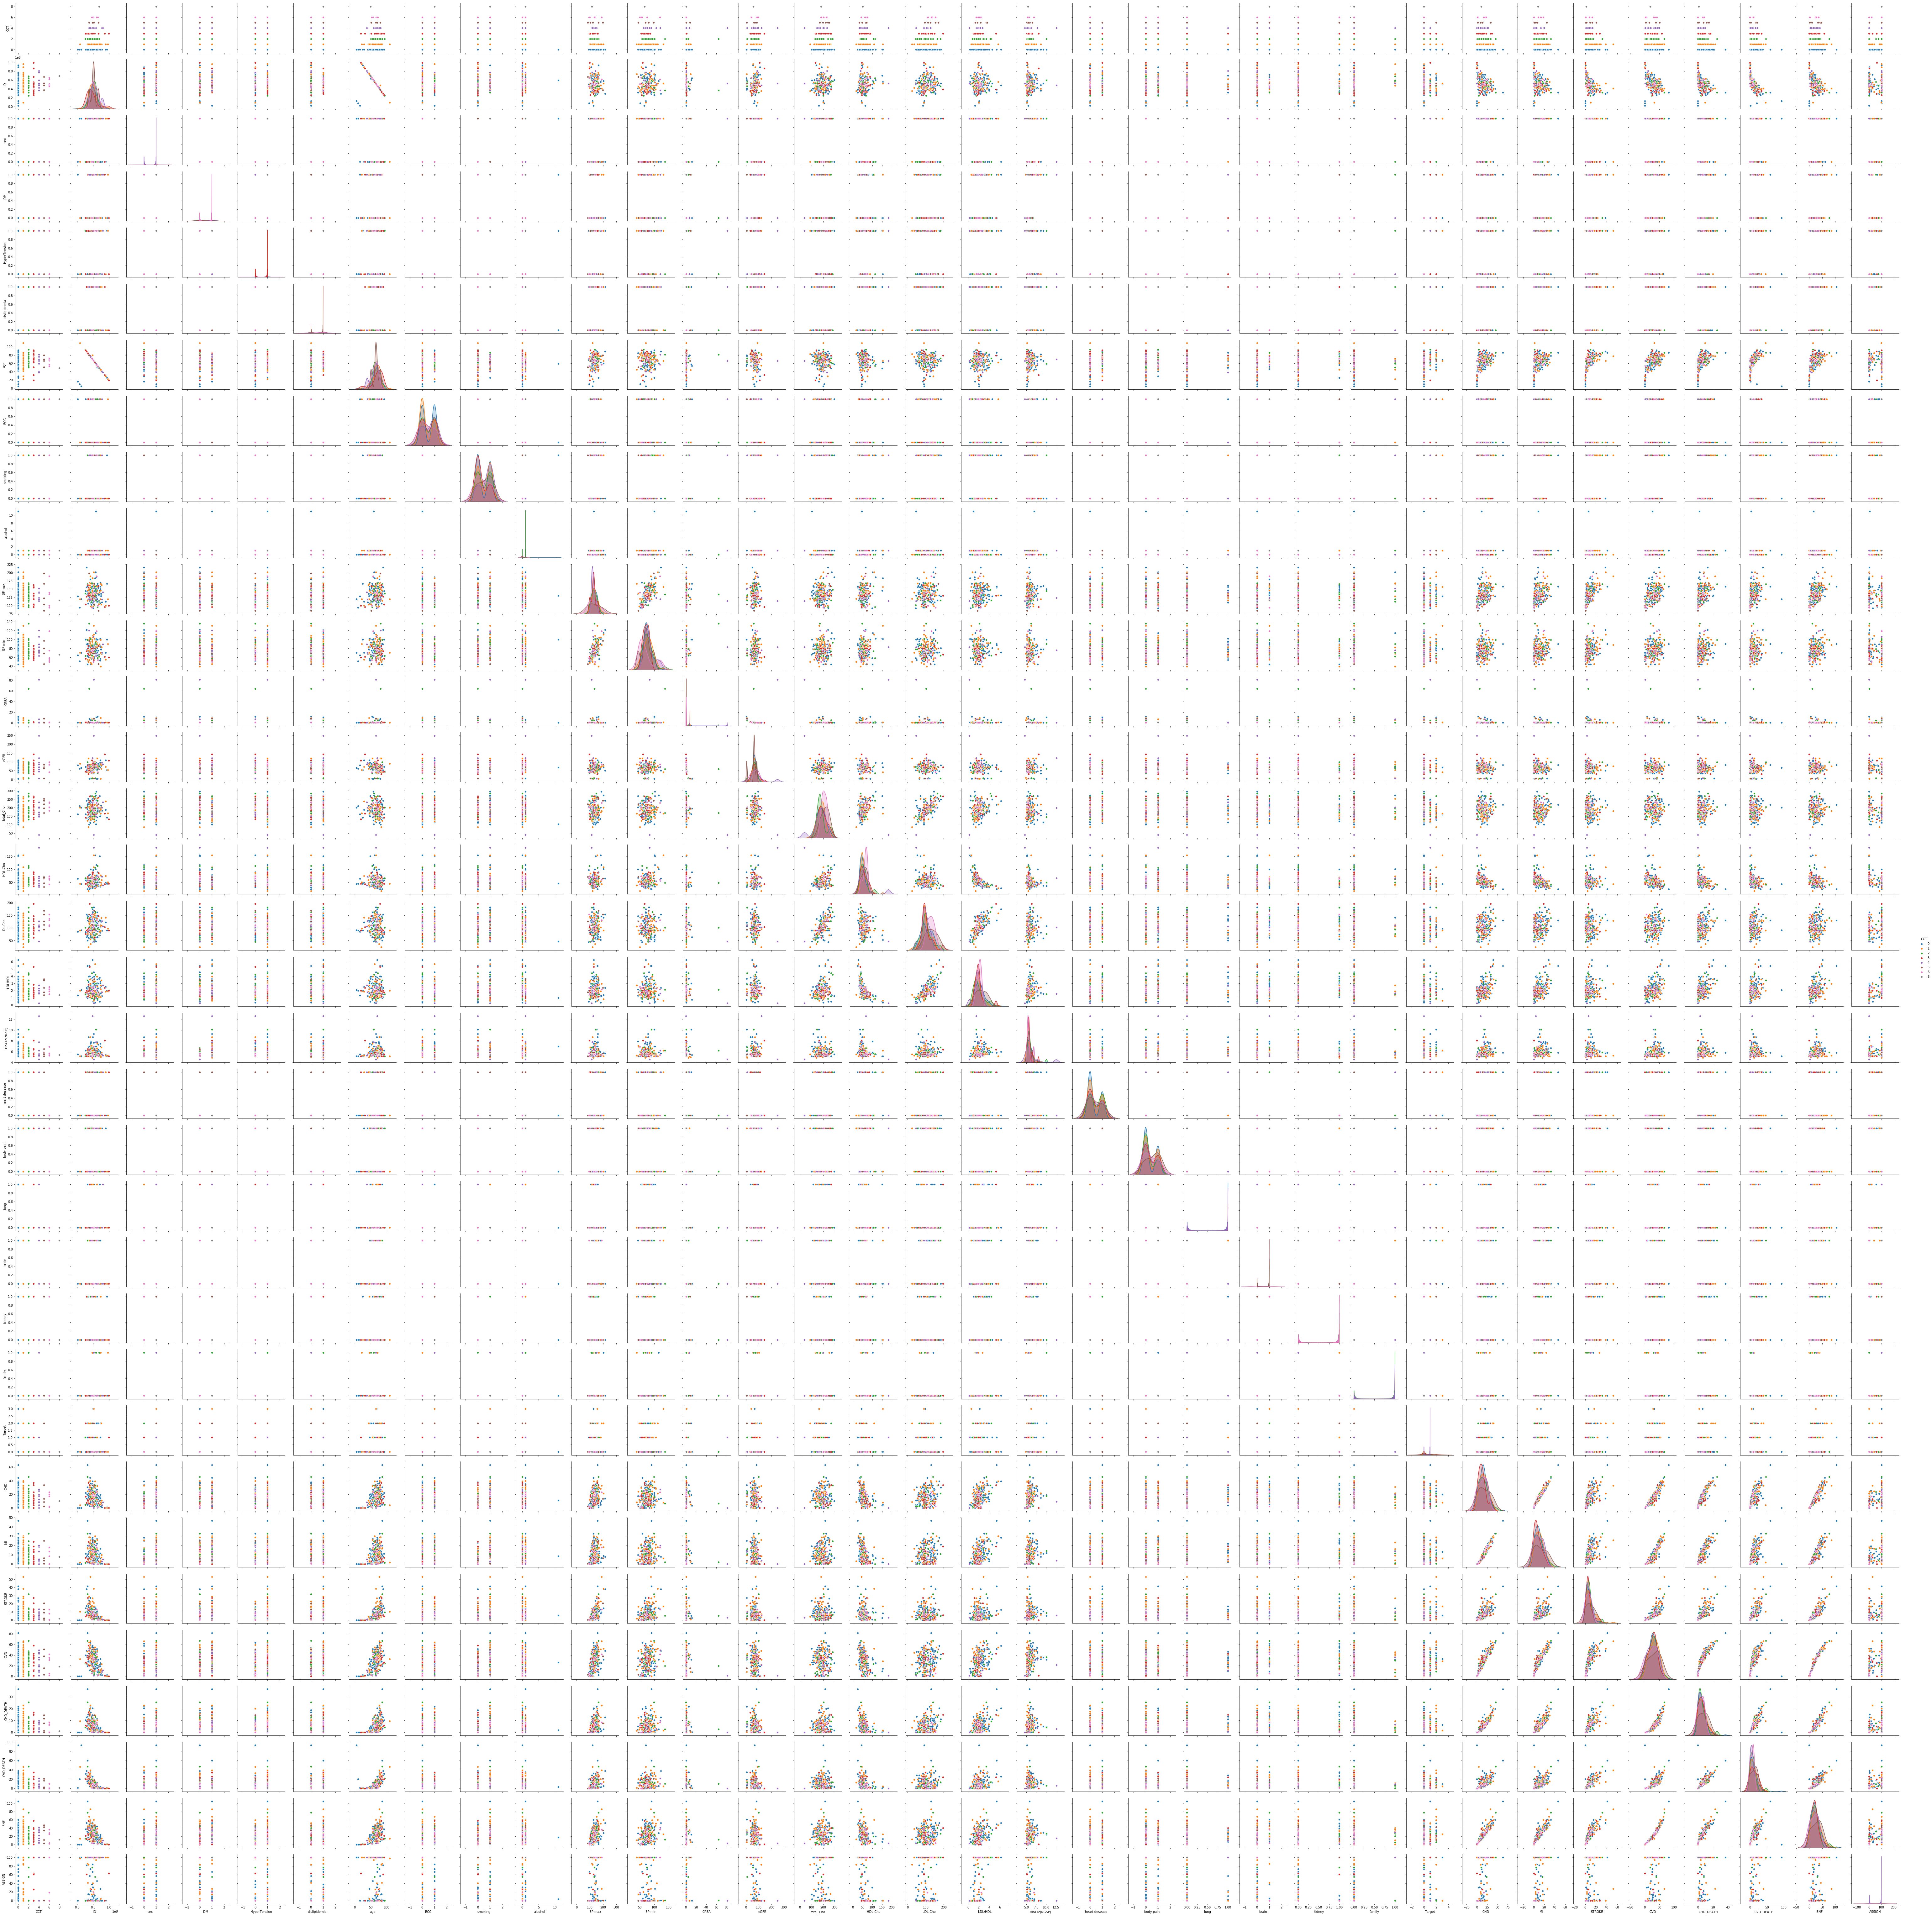

In [0]:
%% time
#sns.pairplot(df, hue='CCT')

In [0]:
train_df.dtypes

ID                int64
sex               int64
DM                int64
HyperTension      int64
dislipidemia      int64
age               int64
ECG               int64
smoking           int64
alcohol           int64
BP _max           int64
BP_min            int64
CREA            float64
eGFR            float64
total_Cho         int64
HDL-Cho           int64
LDL-Cho           int64
LDL/HDL         float64
HbA1c(NGSP)     float64
heartdesease      int64
body_pain         int64
lung              int64
brain             int64
kidney            int64
family            int64
CHD             float64
MI              float64
STROKE          float64
CVD             float64
CHD_DEATH       float64
CVD_DEATH       float64
BNF             float64
ASSIGN          float64
dtype: object

In [0]:
#y = train.pop('CCT')

In [0]:
#X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=42)


In [0]:
import lightgbm as lgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
%matplotlib inline


In [0]:
train_df = pd.read_csv('/content/forHospital - train.csv')

In [0]:
train_df.head()

CCT        ID  sex  DM  ...  CHD_DEATH  CVD_DEATH        BNF     ASSIGN
0    3  37033161    0   0  ...   2.785707  10.300880  12.655053    0.02769
1    0  52052006    1   1  ...   5.553222   8.659718  29.731558  100.00000
2    0  41021305    1   0  ...   8.503450  16.897794  33.435882  100.00000
3    2  37032758    0   0  ...   2.636836   9.853418  11.999663    0.23327
4    1  38100509    1   1  ...  10.715466  21.944423  41.711397  100.00000

[5 rows x 33 columns]

In [0]:
def binary_target(x):
  if x >= 1:
    return 1
  else:
    return 0

In [0]:
train_df['CCT'] = train_df['CCT'].apply(binary_target)

In [0]:
y = train_df.pop('CCT')
x = train_df

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=501)

# Create an LGBM dataset for training
categorical_features = ['age','smoking','LDL/HDL','HbA1c(NGSP)','eGFR']
train_data = lgb.Dataset(data=X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)

# Create an LGBM dataset from the test
test_data = lgb.Dataset(data=X_test, label=y_test, categorical_feature=categorical_features, free_raw_data=False)

# Finally, create a dataset for the FULL training data to give us maximum amount of data to train on after 
# performance has been calibrate
final_train_set = lgb.Dataset(data=train_df, label=y, 
                               categorical_feature=categorical_features, free_raw_data=False)


In [0]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.07,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.64,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }

In [0]:
gridParams = {
    'learning_rate': [0.07],
    'n_estimators': [8,16],
    'num_leaves': [20, 24, 27],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], 
    'colsample_bytree' : [0.64, 0.65],
    'subsample' : [0.7,0.75],
    #'reg_alpha' : [1, 1.2],
    #'reg_lambda' : [ 1.2, 1.4],
    }

In [0]:
mdl = lgb.LGBMClassifier(boosting_type= 'gdbt',
          objective = 'binary',
          n_jobs = 10, 
          silent = True,
          
          max_depth= params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

In [0]:
mdl.get_params().keys()

grid = GridSearchCV(mdl, gridParams, verbose=2, cv=10, n_jobs=-1)

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
# params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
#params['reg_alpha'] = grid.best_params_['reg_alpha']
#params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']
# params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

print('Fitting with params: ')
print(params)

#Train model on selected parameters and number of iterations
lgbm = lgb.train(params,
                 train_data,
                 500,
                 #early_stopping_rounds= 40,
                 verbose_eval= 10
                 )

#Predict on test set
predictions_lgbm_prob = lgbm.predict(X_test)
predictions_lgbm_01 = np.where(predictions_lgbm_prob > 0.52, 1, 0) 

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   27.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.07, 'n_estimators': 16, 'num_leaves': 20, 'objective': 'binary', 'random_state': 501, 'subsample': 0.75}
0.5714285714285714
Fitting with params: 
{'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 'nthread': 5, 'num_leaves': 20, 'learning_rate': 0.07, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.75, 'subsample_freq': 1, 'colsample_bytree': 0.64, 'reg_alpha': 1.2, 'reg_lambda': 1.2, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 'metric': 'auc'}


Overall accuracy of Light GBM model: 0.43478260869565216


<Figure size 432x288 with 0 Axes>

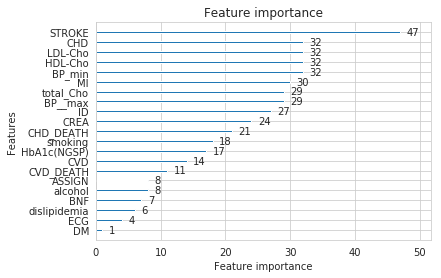

<Figure size 432x288 with 0 Axes>

In [0]:
lgb.plot_importance(lgbm, max_num_features=21, importance_type='split')

#Print accuracy
acc_lgbm = accuracy_score(y_test,predictions_lgbm_01)
print('Overall accuracy of Light GBM model:', acc_lgbm)

#Print Area Under Curve
plt.figure()


<Figure size 432x288 with 0 Axes>

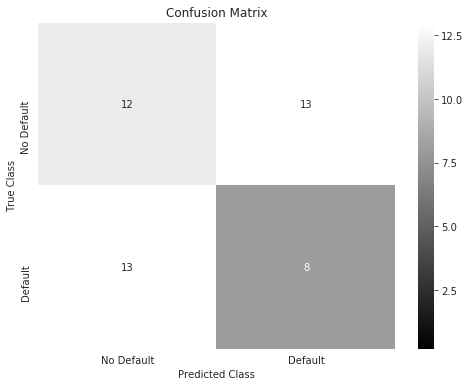

In [0]:
plt.figure()
cm = confusion_matrix(y_test, predictions_lgbm_01)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="gray", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [0]:
preds = np.round(lgbm.predict(X_test))

print('Accuracy score = \t {}'.format(accuracy_score(y_test, preds)))

Accuracy score = 	 0.41304347826086957


In [0]:
test_df = pd.read_csv('/content/forHospital - test.csv')

In [0]:
test_ID = test_df.pop('ID')

In [0]:
final= lgb.train(params,
                 final_train_set,
                 500,
                 #early_stopping_rounds= 40,
                 verbose_eval= 10
                 )


y_pred = np.round(final.predict(test_df)).astype(int)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [0]:
output_df = pd.DataFrame({'ID': test_ID, 'CCT': y_pred})
print(output_df)

          ID  CCT
0   46070751    0
1   39020801    1
2   37041151    0
3   47072655    0
4   41021207    0
5   73051904    0
6   44051401    1
7   52061401    1
8   37110502    1
9   48010188    0
10  72040108    0
11  43040812    0
12  47041114    0
13  35121503    1
14  52042401    1
15  51020252    0
16  77122209    0
17  62011213    0
18  57100802    1
19  43043052    1
20  62082906    0
21  34120853    1
22  45120601    0
23  25032559    1
24  51111952    0
25  53020255    0
26  49042403    1
27   8020805    1
28  69031007    0
29  47080606    1
30  42042104    0


In [0]:
result = output_df.to_csv('outputparam2.csv')

In [0]:
import shutil
new_path =shutil.move('/content/outputparam2.csv','/content/gdrive/My Drive/heart' )

In [0]:
train_df = pd.read_csv('/content/forHospital - train.csv')
test_df = pd.read_csv('/content/forHospital - test.csv')

In [0]:
train_df.loc[ train_df['CCT'] >= 1, 'target'] = 1
train_df.loc[ train_df['CCT'] == 0, 'target'] = 0

In [0]:
train_new = train_df.drop(['CCT'], axis=1)

train_new.head()

ID  sex  DM  HyperTension  ...  CVD_DEATH        BNF     ASSIGN  target
0  37033161    0   0             1  ...  10.300880  12.655053    0.02769     1.0
1  52052006    1   1             1  ...   8.659718  29.731558  100.00000     0.0
2  41021305    1   0             1  ...  16.897794  33.435882  100.00000     0.0
3  37032758    0   0             0  ...   9.853418  11.999663    0.23327     1.0
4  38100509    1   1             1  ...  21.944423  41.711397  100.00000     1.0

[5 rows x 33 columns]

In [0]:
y = train_new.pop('target')
x = train_new

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_new, y, test_size=0.3, random_state=42)

# Create an LGBM dataset for training
categorical_features = ['age','sex','DM','smoking','total_Cho']
train_data = lgb.Dataset(data=X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)

# Create an LGBM dataset from the test
test_data = lgb.Dataset(data=X_test, label=y_test, categorical_feature=categorical_features, free_raw_data=False)

# Finally, create a dataset for the FULL training data to give us maximum amount of data to train on after 
# performance has been calibrate
final_train_set = lgb.Dataset(data=train_df, label=y, 
                               categorical_feature=categorical_features, free_raw_data=False)


In [0]:
params = {'boosting_type': 'dart',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.01,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.64,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }

In [0]:
gridParams = {
    'learning_rate': [0.07],
    'n_estimators': [8,16],
    'num_leaves': [20, 24, 27],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], 
    'colsample_bytree' : [0.64, 0.65],
    'subsample' : [0.7,0.75],
    #'reg_alpha' : [1, 1.2],
    #'reg_lambda' : [ 1.2, 1.4],
    }

In [0]:
mdl = lgb.LGBMClassifier(boosting_type= 'dart',
          objective = 'binary',
          n_jobs = 10, 
          silent = True,
          
          max_depth= params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

In [0]:
mdl.get_params().keys()

grid = GridSearchCV(mdl, gridParams, verbose=2, cv=10, n_jobs=-1)

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
# params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
#params['reg_alpha'] = grid.best_params_['reg_alpha']
#params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']
# params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

print('Fitting with params: ')
print(params)

#Train model on selected parameters and number of iterations
lgbm = lgb.train(params,
                 train_data,
                 500,
                 #early_stopping_rounds= 40,
                 verbose_eval= 10
                 )

#Predict on test set
predictions_lgbm_prob = lgbm.predict(X_test)
predictions_lgbm_01 = np.where(predictions_lgbm_prob > 0.50, 1, 0) 

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   24.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.07, 'n_estimators': 8, 'num_leaves': 20, 'objective': 'binary', 'random_state': 501, 'subsample': 0.7}
0.5345911949685535
Fitting with params: 
{'boosting_type': 'dart', 'max_depth': -1, 'objective': 'binary', 'nthread': 5, 'num_leaves': 20, 'learning_rate': 0.07, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.7, 'subsample_freq': 1, 'colsample_bytree': 0.64, 'reg_alpha': 1.2, 'reg_lambda': 1.2, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 'metric': 'auc'}


Overall accuracy of Light GBM model: 0.5942028985507246


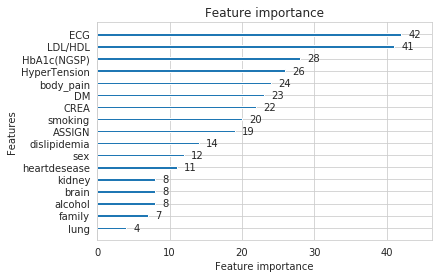

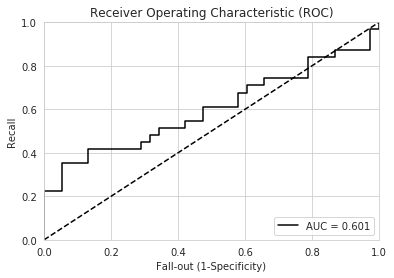

AUC score: 0.6010186757215621


In [0]:
lgb.plot_importance(lgbm, max_num_features=21, importance_type='split')

#Print accuracy
acc_lgbm = accuracy_score(y_test,predictions_lgbm_01)
print('Overall accuracy of Light GBM model:', acc_lgbm)

#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, predictions_lgbm_prob)

roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'black', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

<Figure size 432x288 with 0 Axes>

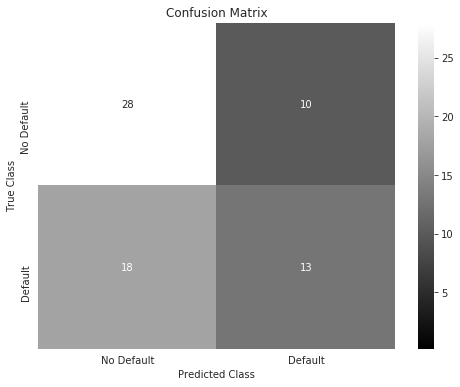

In [0]:
plt.figure()
cm = confusion_matrix(y_test, predictions_lgbm_01)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="gray", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [0]:
preds = np.round(lgbm.predict(X_test))

print('Accuracy score = \t {}'.format(accuracy_score(y_test, preds)))
print('Precision score = \t {}'.format(precision_score(y_test, preds)))
print('Recall score =   \t {}'.format(recall_score(y_test, preds)))
print('F1 score =      \t {}'.format(f1_score(y_test, preds)))

Accuracy score = 	 0.5942028985507246
Precision score = 	 0.5652173913043478
Recall score =   	 0.41935483870967744
F1 score =      	 0.4814814814814815


In [0]:
final= lgb.train(params,
                 final_train_set,
                 500,
                 #early_stopping_rounds= 40,
                 verbose_eval= 10
                 )
y_pred = np.round(final.predict(test_df)).astype(int)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [0]:
output_df = pd.DataFrame({'ID': test_ID, 'CCT': y_pred})
print(output_df)

          ID  CCT
0   46070751    1
1   39020801    1
2   37041151    1
3   47072655    1
4   41021207    0
5   73051904    1
6   44051401    1
7   52061401    1
8   37110502    0
9   48010188    1
10  72040108    0
11  43040812    1
12  47041114    0
13  35121503    0
14  52042401    0
15  51020252    1
16  77122209    1
17  62011213    0
18  57100802    1
19  43043052    1
20  62082906    0
21  34120853    0
22  45120601    0
23  25032559    1
24  51111952    1
25  53020255    1
26  49042403    0
27   8020805    0
28  69031007    0
29  47080606    0
30  42042104    0


In [0]:
result2 = output_df.to_csv('output1class.csv')
new_path =shutil.move('/content/output1class.csv','/content/gdrive/My Drive/heart' )

In [0]:
!pip install featuretools

In [0]:
train = pd.read_csv('/content/forHospital - train.csv')
test = pd.read_csv('/content/forHospital - test.csv')

In [0]:
import featuretools as ft
target = train["CCT"].values
full = pd.concat([train, test])

In [0]:
full.head()

CCT        ID  sex  DM  ...  CHD_DEATH  CVD_DEATH        BNF     ASSIGN
0    3  37033161    0   0  ...   2.785707  10.300880  12.655053    0.02769
1    0  52052006    1   1  ...   5.553222   8.659718  29.731558  100.00000
2    0  41021305    1   0  ...   8.503450  16.897794  33.435882  100.00000
3    2  37032758    0   0  ...   2.636836   9.853418  11.999663    0.23327
4    1  38100509    1   1  ...  10.715466  21.944423  41.711397  100.00000

[5 rows x 33 columns]